# Obtain regulons based on gene expression similarity

In [3]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path+'/correlation_enrichment/' not in sys.path:
    sys.path.insert(0,module_path+'/correlation_enrichment/')
if module_path+'/networks/' not in sys.path:
    sys.path.insert(0,module_path+'/networks/')
if module_path+'/data_expression/' not in sys.path:
    sys.path.insert(0,module_path+'/data_expression/')

import pandas as pd
import matplotlib.pyplot as plt

from library import SimilarityCalculator
from library_regulons import *


In [4]:
dataPath=module_path+'/data_expression/'
genes = pd.read_csv(dataPath + 'mergedGenes_RPKUM.tsv', sep='\t', index_col=0)
conditions = pd.read_csv(dataPath + 'conditions_mergedGenes.tsv', sep='\t', index_col=None)

## Set parameters

### Compare parameters for similarity calculation (expression scaling, way of combining samples)

In [5]:
# Set parameters
# Cosine similarity threshold
threshold=0.95
#Set if want to compute at multiple thresholds
thresholds=[threshold]
#thresholds=[0.85,0.9,0.92,0.94,0.96,0.98,0.99]
#Number of neighbours to obtain for each gene
neighbours_n=30
#Scaling of genes
#scale: 'minmax' (from 0 to 1) or 'mean0std1' (to mean0 and std1)
scale='minmax'
#Log transform expression values before scaling
use_log=True
#Calculate inverse profiles
inverse=False
#Batches: 'replicate', 'strain', 'none' 
# replicate,strain - computes neighbours for each replicate/strain separately 
# and retains neighbours present at some threshold in all replicates/strains
# none - uses all samples at the same time
batches='none'

#Prepare data
if batches=='none':
    batches=None
if batches=='strain':
    batches=list(conditions[list((conditions["Strain"]=='comH') | (conditions["Strain"]=='cudA') | (conditions["Strain"]=='gbfA')  | (conditions["Strain"]=='mybBGFP') | (conditions["Strain"]=='pkaR'))]
                 .loc[:,'Strain'])
if batches=='replicate':
    batches=list(conditions[list((conditions["Strain"]=='comH') | (conditions["Strain"]=='cudA') | (conditions["Strain"]=='gbfA')  | (conditions["Strain"]=='mybBGFP') | (conditions["Strain"]=='pkaR'))]
                .loc[:,'Replicate'])

genes_sub=genes.T[list((conditions["Strain"]=='comH')
                        | (conditions["Strain"]=='cudA')
                        | (conditions["Strain"]=='gbfA')
                        | (conditions["Strain"]=='mybBGFP')
                        | (conditions["Strain"]=='pkaR'))].T

genes_test=genes.T[list((conditions["Replicate"]=='AX4_bio1'))].T
neighbour_calculator=NeighbourCalculator(genes_sub)
test_index,test_query=NeighbourCalculator.get_index_query(genes_test,inverse=inverse,scale=scale,log=use_log)
gene_names=np.array(genes_test.index)
#Calculate neighbours
if batches!=None:
    results = neighbour_calculator.neighbours(neighbours_n, inverse=inverse, scale=scale, log=use_log, batches=batches)
    result=neighbour_calculator.merge_results(results,threshold,len(set(batches)))
else:
    result = neighbour_calculator.neighbours(neighbours_n, inverse=inverse, scale=scale, log=use_log, batches=batches)

#Filter neighbours on similarity
for threshold in thresholds:
    result_filtered=NeighbourCalculator.filter_similarities(result,threshold)
    #Calculate MSE for each gene pair - 
    #compare similarity from gene subset to similarity of the gene pair in gene test set 
    sq_errors=[]
    for pair,similarity in result_filtered.items():
        gene1=pair[0]
        gene2=pair[1]
        similarity_test=SimilarityCalculator.calc_cosine(test_index[gene_names==gene1].flatten(),
                                                         test_query[gene_names==gene2].flatten())
        se=(similarity-similarity_test)**2
        # Happens if at least one vector has all 0 values
        if not np.isnan(se):
            sq_errors.append(se)
    print('threshold:',threshold,'MSE:',mean(sq_errors),'N:',len(result_filtered))


/home/karin/Documents/git/orange3venv/lib/python3.6/site-packages/numba/ir_utils.py:1959: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'forest' of function 'initialise_search'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../orange3venv/lib/python3.6/site-packages/pynndescent/pynndescent_.py", line 72:
@numba.njit()
def initialise_search(
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/home/karin/Documents/git/baylor-dicty/correlation_enrichment/library.py:235: RuntimeWarning: invalid value encountered in double_scalars
  return np.inner(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))


threshold: 0.95 MSE: 0.006849992730332485 N: 16043


#### Results summary
Sample: comH_r1, cudA_r2, gbfA_r1,mybBGBF_bio1,pkaR_bio1 and test sample: AX4_bio1; not inverse: threshold 0.95; neighbours 30

Comparison of scaling parameters:
minmax, no log: MSE 0.01615798890022193, filtered N: 57921
minmax, log: MSE 0.008855992300398607, filtered: 191347
mean0std1, no log: MSE 0.10903301209390322, filtered: 14100
mean0std1, log: MSE 0.008840844803079855, filtered: 6217
mean0std1, log, threshold 0.935: MSE 0.008617332426242763, filtered: 14239
Log on mean0std1 does not seem to perform better because of lesser number of retained pairs (eg. possibly more correlated ones, as shown when lowering filtering threshold for log based calculations

Compare MSE at different thresholds, minmax, log, not inverse, 300 neighbours, no batches
threshold: 0.99 MSE: 0.004401159883607221 N: 27422,
threshold: 0.98 MSE: 0.008960403278511933 N: 235707,
threshold: 0.97 MSE: 0.010837772836915213 N: 554577,
threshold: 0.95 MSE: 0.012256426645819427 N: 1246669,
threshold: 0.93 MSE: 0.012841511138263213 N: 1788086,
threshold: 0.91 MSE: 0.013112523538440932 N: 2091354

Use of batches by replicate
minmax, log, batches: MSE 0.0005413249414331597, filtered: 243
Try to lower threshold for merging to obtain similar number of results: However, even when lowering the threshold substantially (eg. to max of lowest similarity of individual strains - as pair must be present in all strains) the number of filtered pairs remained at 270

Compare result by using batches on samples or strains
Sample strains: comH, cudA, gbfA, mybBGBF, pkaR (each 2 replicates) and test sample: AX4_bio1; not inverse, threshold 0.95, neighbours 30, minmax, log
By strain: 0.0006956959575191145 559, when lowering merging threshold to max of any result's min similarity there is 762 pairs
By replicate: 6.592793901930816e-05 41, when lowering the merging threshold as above got to 54 pairs


### Compare number of obtained neighbours above similarity threshold by setting different N of neighbours in the search

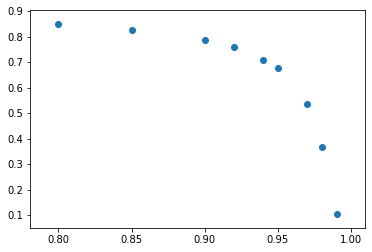

In [7]:
neighbour_calculator = NeighbourCalculator(genes)
inverse=False
scale='minmax'
use_log=True
#Number of computed neighbours to compare
N1=2
N2=3
#Similarity thresholds
thresholds=[0.8,0.85,0.9,0.92,0.94,0.95,0.97,0.98,0.99]
#Compute similarities
#Can add parameter random (in function neighbours) to set different seed 
result0=np.array(list(neighbour_calculator.neighbours(N1,inverse,scale=scale,log=use_log).values()))
result1=np.array(list(neighbour_calculator.neighbours(N2,inverse,scale=scale,log=use_log).values()))
# What percent of shorter result's values is missing 
#(eg. how many more similarities at specified threshold are present in result with more neighbours (N2), 
# given as percentage of similarities at threhold from result with less neighbours (N1))
differences=[]
for threshold in thresholds:
    differences.append((sum(result1>=threshold)-sum(result0>=threshold))/len(result0))
plt.scatter(thresholds,differences)

Increasing N of neighbours results in siginificantly increased search time (from seconds to minutes).

Regardless of N of compared neighbours with parameters scale=minmax, log=True, inverse=False there seems to be a knee at similarity=0.95. The difference in N of obtained pairs at any threshold depends heavily on difference of compared N1 and N2.

On all genes:
For: scale=minmax, log=True, inverse=False;
Shows thresholds and differences

With neighbours 90 and 100: 
{0.8: 0.0919429801303846,
 0.85: 0.08757603169156868,
 0.9: 0.0797643927342296,
 0.92: 0.0747995882591472,
 0.94: 0.06614783160215021,
 0.95: 0.05897147966769602,
 0.97: 0.030408517628954947,
 0.98: 0.011565135115464196,
 0.99: 0.0003566341225033012}

With neighbours 250 and 300:
{0.8: 0.15846030821583645,
 0.85: 0.14988588269014977,
 0.9: 0.13441715555935016,
 0.92: 0.12286287322535006,
 0.94: 0.10321746780016587,
 0.95: 0.08689571949553593,
 0.97: 0.03140208018246573,
 0.98: 0.0075952425964775335,
 0.99: 0.0}

With neighbours 300 and 310:
{0.8: 0.026306523784654787,
 0.85: 0.02486818697868655,
 0.9: 0.022217109835209428,
 0.92: 0.020215100497172556,
 0.94: 0.01687098335525039,
 0.95: 0.01402936004208585,
 0.97: 0.004912777331506044,
 0.98: 0.0010464107378820762,
 0.99: 0.0}

With neighbours 300 and 400:
{0.8: 0.26040938111687456,
 0.85: 0.2459931932319785,
 0.9: 0.21868104451164896,
 0.92: 0.19832669873662792,
 0.94: 0.16383019468529134,
 0.95: 0.1344312786317128,
 0.97: 0.04437049185446988,
 0.98: 0.007848717812275061,
 0.99: 0.0}
 
With neighbours 30 and 400:
{0.8: 7.517435541285033,
 0.85: 7.133719717094834,
 0.9: 6.469281868095933,
 0.92: 5.998698212689623,
 0.94: 5.203611369772997,
 0.95: 4.545878659719649,
 0.97: 2.084528974110627,
 0.98: 0.7175401825616559,
 0.99: 0.026200805364111155}
 
With neighbours 100 and 400:
{0.8: 1.670834934350487,
 0.85: 1.581152357478234,
 0.9: 1.4285127878316448,
 0.92: 1.3180810286496163,
 0.94: 1.1282372566844419,
 0.95: 0.9730991630975699,
 0.97: 0.4022801608202206,
 0.98: 0.12323271135769379,
 0.99: 0.0005182609673579937}
 
With neighbours 200 and 400:
 {0.8: 0.4361484072449974,
 0.85: 0.412617918149787,
 0.9: 0.3709839505106742,
 0.92: 0.3396469738651342,
 0.94: 0.2868074013833705,
 0.95: 0.24303973323287179,
 0.97: 0.09090551080230366,
 0.98: 0.023746848319847257,
 0.99: 0.0}
 
For 2 runs with 300 neighbours and different random seed the differences are 0 or in range of 3e-07.
 
For neighbours  with scale=minmax, log=False, inverse=False, threhold=0.95
N=20 vs N=30 0.0102, N=20 vs N=20, different seed =1.004e-05, N=30 vs N=40: 0.00299, N=30 vs N=30, different seed: -3.320e-05

## Visualise how similarity at certain threshold looks like

('DDB_G0267578', 'DDB_G0272835')
('DDB_G0267702', 'DDB_G0268318')
('DDB_G0267762', 'DDB_G0273275')
('DDB_G0267762', 'DDB_G0280787')
('DDB_G0267792', 'DDB_G0275163')
('DDB_G0267792', 'DDB_G0294635')
('DDB_G0267862', 'DDB_G0290549')
('DDB_G0267862', 'DDB_G0277151')
('DDB_G0267936', 'DDB_G0268174')


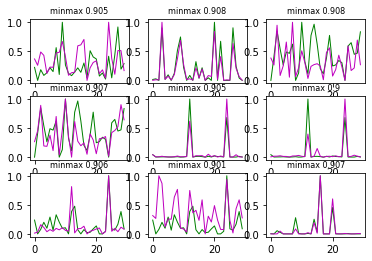

In [10]:
#sim_threshold - upper border, step - sim_threshold+step=upper border
#Plots first 9 pairs with such similarity (some genes may be repeated)
sim_threshold = 0.90
step = 0.01
#Show only first n points from gene table as there is too many points to show at once
first_n_points=30

neighbour_calculator = NeighbourCalculator(genes)
neighbours = neighbour_calculator.neighbours(3, False, scale='minmax',log=True)
# Plot how it looks to have similarity above threshold:
max_plot = 1
for gene_pair, sim in neighbours.items():
    if max_plot <= 9:
        if sim_threshold <= sim < sim_threshold + step:
            sim=round(sim,3)
            plt.subplot(3, 3, max_plot)
            plt.title('minmax '+str(sim),fontdict = {'size': 8 })
            print(gene_pair)
            gene1 = pp.minmax_scale(list(genes.loc[gene_pair[0],:].iloc[:first_n_points]))
            gene2 = pp.minmax_scale(list(genes.loc[gene_pair[1],:].iloc[:first_n_points]))
            plt.plot(list(range(first_n_points)), gene1, color='g', linewidth=1)
            plt.plot(list(range(first_n_points)), gene2, color='m', linewidth=1)
            max_plot += 1

